In [2]:
import numpy as np
import tifffile
import zarr
import os
import napari
from skimage.measure import regionprops
from scipy.ndimage import label

# Step 1: Read the TIFF files
directory = "Fluo-C3DL-MDA231_TRAIN/01/"
#zarr_directory = "/Users/kharrington/git/cmalinmayor/motile-plugin/data/zarr_data.zarr"
file_names = sorted([f for f in os.listdir(directory) if f.endswith('.tif')])


In [4]:
im=tifffile.imread(os.path.join(directory, file_names[0]))
#im.shape


In [5]:
viewer=napari.Viewer()
viewer.add_image(im)

<Image layer 'im' at 0x7f78fb021660>

In [6]:

# Step 2: Combine them into a 3D array
images = [tifffile.imread(os.path.join(directory, fname)) for fname in file_names]
stack = np.stack(images, axis=0)


In [7]:
viewer.add_image(stack)

<Image layer 'stack' at 0x7f78b7a907f0>

In [8]:
directory = "Fluo-C3DL-MDA231_TRAIN/01_GT/TRA/"
#zarr_directory = "/Users/kharrington/git/cmalinmayor/motile-plugin/data/zarr_data.zarr"
file_names = sorted([f for f in os.listdir(directory) if f.endswith('.tif')])
masks = [tifffile.imread(os.path.join(directory, fname)) for fname in file_names]
masks = np.stack(masks, axis=0)
print(masks.shape)

(12, 30, 512, 512)


In [9]:
viewer.add_labels(masks)

<Labels layer 'masks' at 0x7f78b42f8910>

In [10]:
out=regionprops(masks[0])

In [11]:
len(out)

31

In [12]:
#Create list with [t, z,y,x]
rows=[]
for t,m in enumerate(masks):
    out=regionprops(m)
    for o in out:
        rows.append([t,*o.centroid])
    

In [13]:
print(rows)

[[0, 7.914194065757819, 473.57898957497997, 249.30392943063353], [0, 8.187919463087248, 427.9440715883669, 468.5682326621924], [0, 7.977178423236515, 266.103734439834, 429.603734439834], [0, 7.806301050175029, 377.6744457409568, 350.1656942823804], [0, 7.971870604781997, 215.62447257383965, 265.4317862165963], [0, 7.930769230769231, 350.89846153846156, 304.89384615384614], [0, 7.923882681564246, 403.0831005586592, 115.99930167597765], [0, 7.985026737967915, 429.17005347593584, 89.4096256684492], [0, 8.033505154639176, 250.20103092783506, 17.832474226804123], [0, 7.991169977924945, 191.48013245033113, 130.57615894039736], [0, 7.751131221719457, 208.9577677224736, 122.66515837104072], [0, 9.771309771309772, 250.21413721413722, 308.987525987526], [0, 15.054388133498145, 486.3337453646477, 409.4091470951792], [0, 21.036328871892927, 169.87189292543022, 326.26003824091777], [0, 20.9672131147541, 172.79016393442623, 357.2245901639344], [0, 22.056338028169016, 207.34272300469485, 318.11580594

In [14]:
viewer.add_points(rows)

<Points layer 'Points' at 0x7f78de8182e0>

In [18]:
cells=[]
#adds id number to each cell
for i, row in enumerate(rows):
    cells.append({'id': i, 't': row[0], 'z':row[1], 'y': row[2], 'x':row[3], 'pos':(row[1], row[2], row[3])})


In [52]:
#creates graph from the cells
import networkx as nx 

graph=nx.DiGraph()
graph.add_nodes_from([(cell['id'], cell) for cell in cells])


In [53]:
#adding candidate edges to the graph w the constriction to be less than 20 pixels apart between two time points
import utils
utils.add_cand_edges(graph, 20)


Extracting candidate edges


100%|██████████| 12/12 [00:00<00:00, 7860.64it/s]


In [106]:
import motile
# create a motile solver
graph_m = motile.TrackGraph(graph)
solver = motile.Solver(graph_m)

In [107]:
#Motile finds the minimum cost, so we need the weight to be <0
from motile.costs import EdgeDistance

solver.add_costs(
    EdgeDistance(
        weight=-5,
        position_attributes=('z', 'y', 'x')
        ))


In [105]:
# from motile.costs import NodeSelection, EdgeSelection

# solver.add_costs(
#     NodeSelection(
#         weight=-1.0,
#         constant=1.0))
# solver.add_costs(
#     EdgeSelection(
#         weight=-1.0,
#         constant=1.0))

In [108]:
#change depending on splitting/merging (set to 1 if there is no splitting or merging)
from motile.constraints import MaxParents, MaxChildren

solver.add_constraints(MaxParents(1))
solver.add_constraints(MaxChildren(2))

In [109]:
#Cost of starting new track
from motile.costs import Appear

solver.add_costs(Appear(constant=1.0))

In [110]:
solution = solver.solve()

Could not create Gurobi backend: Gurobi error in ilpy/impl/solvers/GurobiBackend.cpp:22: PIP license can only be used from gurobipy interface


In [111]:
def get_selected_subgraph( solver,
        solution) :
    """Return TrackGraph with only the selected nodes/edges from the solution.

    Args:
        solution:
            The solution to use. If not provided, the last solution is used.

    Returns:
        A new TrackGraph with only the selected nodes and edges.

    Raises:
        RuntimeError: If no solution is provided and the solver has not been solved
        yet.
    """
    from motile.variables import EdgeSelected, NodeSelected

    # if solution is None:
        # solution = self.solution

    # TODO:
    # in theory this could be made more efficient by using a nx.DiGraph view
    # but TrackGraph itself doesn't provide views (and isn't a subclass)
    if not solution:
        raise RuntimeError(
            "No solution available. Run solve() first or manually pass a solution."
        )

    node_selected = solver.get_variables(NodeSelected)
    edge_selected = solver.get_variables(EdgeSelected)
    selected_graph = motile.TrackGraph()

    for node_id, node in solver.graph.nodes.items():
        if solution[node_selected[node_id]] > 0.5:
            selected_graph.add_node(node_id, node)

    for edge_id, edge in solver.graph.edges.items():
        if solution[edge_selected[edge_id]] > 0.5:
            selected_graph.add_edge(edge_id, edge)

    return selected_graph

In [112]:
out_graph=get_selected_subgraph(solver,solution)

In [113]:
#Change graph format to nx which is compatible with napari
from motile_toolbox.candidate_graph import graph_to_nx
out_nx_graph=graph_to_nx(out_graph)

In [114]:
from motile_toolbox.visualization import to_napari_tracks_layer


In [115]:
edges, properties, graph_output=to_napari_tracks_layer(out_nx_graph, frame_key='t')

In [116]:
viewer.add_tracks(edges, graph=graph_output)

<Tracks layer 'data [2]' at 0x7f78b7886c20>

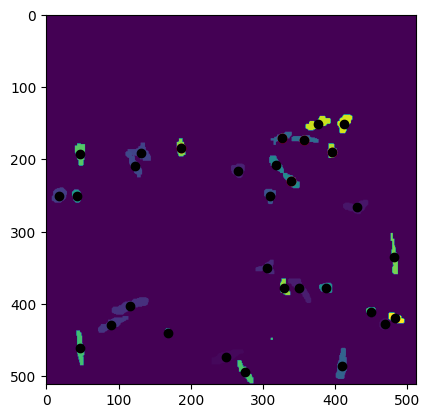

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.max(masks,axis=1)[0]),np.unique(masks[0,21])
sub = df[df['t'] == 0]
sub = sub[(sub['z'] >20) & (sub['z'] <22)]
plt.scatter(sub['x'], sub['y'], c='r')
plt.scatter(**df[df['t']==0][['x','y']],c='k')